In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
import pandas as pd

# Use relative paths to reach the data folder
benin_df = pd.read_csv("../data/benin_clean.csv")
sierra_df = pd.read_csv("../data/sierra_leone_clean.csv")
togo_df = pd.read_csv("../data/togo_clean.csv")

# Add country column
benin_df["Country"] = "Benin"
sierra_df["Country"] = "Sierra Leone"
togo_df["Country"] = "Togo"

# Concatenate into one DataFrame
df = pd.concat([benin_df, sierra_df, togo_df], ignore_index=True)


In [6]:
import plotly.io as pio
pio.renderers.default = 'browser'


In [7]:
import plotly.express as px
import plotly.io as pio

# Use browser to display the plot
pio.renderers.default = 'browser'

# GHI Boxplot
fig_ghi = px.box(df, x='Country', y='GHI', color='Country', title='GHI Distribution by Country')
fig_ghi.show()

# DNI Boxplot
fig_dni = px.box(df, x='Country', y='DNI', color='Country', title='DNI Distribution by Country')
fig_dni.show()

# DHI Boxplot
fig_dhi = px.box(df, x='Country', y='DHI', color='Country', title='DHI Distribution by Country')
fig_dhi.show()

In [8]:
# Summary table: Mean, Median, Std per Country for GHI, DNI, DHI
summary_table = df.groupby('Country')[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std']).round(2)

# Display the summary table
print(summary_table)


                 GHI                    DNI                    DHI         \
                mean median     std    mean median     std    mean median   
Country                                                                     
Benin         240.56    1.8  331.13  167.19   -0.1  261.71  115.36    1.6   
Sierra Leone  196.44    0.0  291.24  104.53   -0.1  201.70  110.11   -0.4   
Togo          219.96    2.1  315.85  145.37    0.0  246.26  110.84    2.5   

                      
                 std  
Country               
Benin         158.69  
Sierra Leone  154.17  
Togo          150.93  


Lets check the normality of GHI for each country using visual inspection with hisograms and Q-Q plots then Shapiro-Wilk test

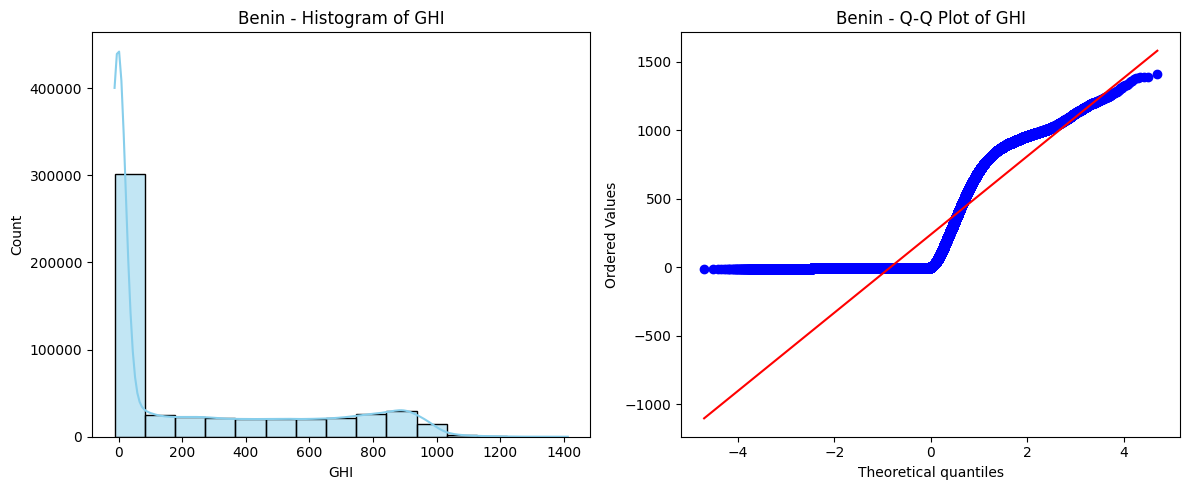

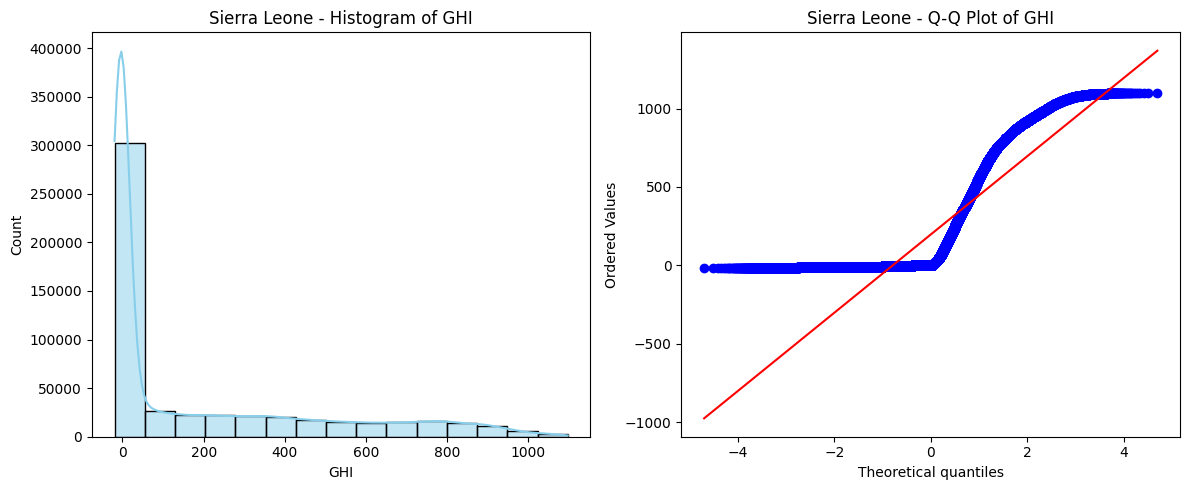

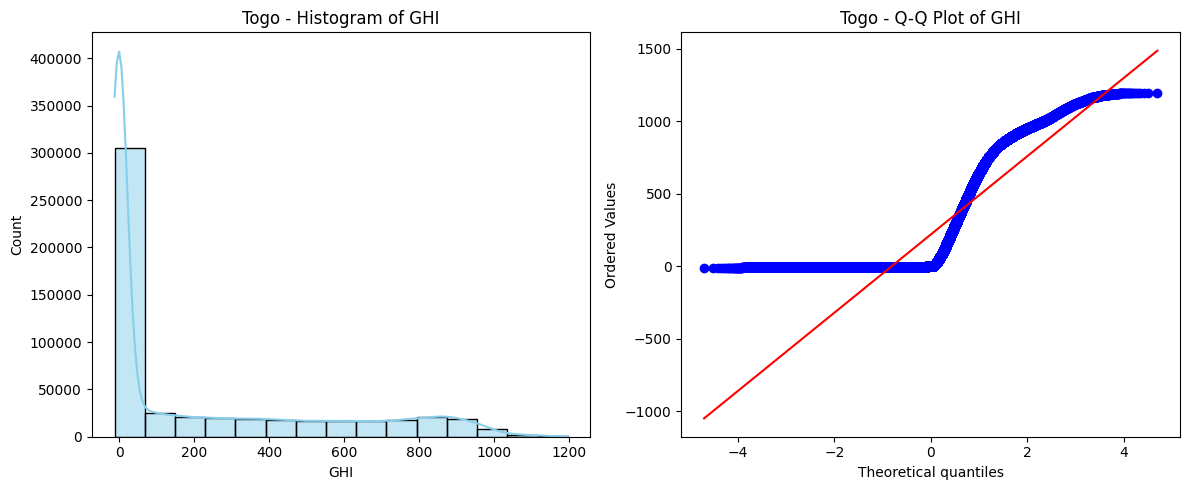

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

countries = df['Country'].unique()

for country in countries:
    ghi = df[df['Country'] == country]['GHI'].dropna()

    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(ghi, kde=True, bins=15, color='skyblue')
    plt.title(f'{country} - Histogram of GHI')

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(ghi, dist="norm", plot=plt)
    plt.title(f'{country} - Q-Q Plot of GHI')
    
    plt.tight_layout()
    plt.show()


In [10]:
from scipy.stats import shapiro

for country in countries:
    ghi = df[df['Country'] == country]['GHI'].dropna()
    stat, p = shapiro(ghi)
    print(f"{country} - Shapiro-Wilk p-value: {p:.4f} {'(Normal)' if p > 0.05 else '(Not normal)'}")


c:\Users\helin\solar-farm-discovery\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 525600.



Benin - Shapiro-Wilk p-value: 0.0000 (Not normal)
Sierra Leone - Shapiro-Wilk p-value: 0.0000 (Not normal)
Togo - Shapiro-Wilk p-value: 0.0000 (Not normal)


since all 3 are not normal we use Kruskals-Wallis H-test instead of ANOVA

In [11]:
from scipy.stats import kruskal

# Group GHI by country
ghi_groups = [group['GHI'].dropna().values for name, group in df.groupby('Country')]

# Run Kruskal–Wallis test
stat, p = kruskal(*ghi_groups)

print(f"Kruskal–Wallis H-statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

# Interpretation
if p < 0.05:
    print("➡️ Statistically significant differences in GHI between countries (p < 0.05).")
else:
    print("➡️ No statistically significant difference in GHI between countries (p ≥ 0.05).")


Kruskal–Wallis H-statistic: 4427.3640
P-value: 0.0000
➡️ Statistically significant differences in GHI between countries (p < 0.05).


Since Kruskal–Wallis tells us there’s a difference, but not where, we can now run Dunn's post-hoc test (with Bonferroni correction) to see which pairs differ.

In [12]:
import scikit_posthocs as sp
import pandas as pd

# Dunn’s test with Bonferroni correction
dunn_result = sp.posthoc_dunn(df, val_col='GHI', group_col='Country', p_adjust='bonferroni')

print("Dunn’s Test with Bonferroni Correction:")
print(dunn_result)


Dunn’s Test with Bonferroni Correction:
                 Benin  Sierra Leone      Togo
Benin         1.000000           0.0  0.525915
Sierra Leone  0.000000           1.0  0.000000
Togo          0.525915           0.0  1.000000


| Comparison                | Adjusted p-value | Interpretation                  |
| ------------------------- | ---------------- | ------------------------------- |
| **Benin vs Sierra Leone** | 0.0000           |  **Significant difference**    |
| **Benin vs Togo**         | 0.5259           |  **No significant difference** |
| **Sierra Leone vs Togo**  | 0.0000           |  **Significant difference**    |

Sierra Leone has significantly different GHI values compared to both Benin and Togo.

Benin and Togo do not differ significantly from each other in terms of GHI.


In [13]:
import plotly.express as px

# Calculate average GHI per country
avg_ghi = df.groupby('Country')['GHI'].mean().reset_index().sort_values(by='GHI', ascending=False)

# Create bar chart
fig_avg_ghi = px.bar(
    avg_ghi,
    x='Country',
    y='GHI',
    title='Average GHI by Country',
    color='Country',
    text='GHI'
)

fig_avg_ghi.show()


In [14]:
# Import required library
import pandas as pd

# Create the summary table
summary_table = df.groupby('Country')[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std']).round(2)

# Flatten multi-level column index
summary_table.columns = ['_'.join(col).strip() for col in summary_table.columns.values]

# Display the summary table
print("Summary Table for GHI, DNI, and DHI per Country:\n")
print(summary_table)


Summary Table for GHI, DNI, and DHI per Country:

              GHI_mean  GHI_median  GHI_std  DNI_mean  DNI_median  DNI_std  \
Country                                                                      
Benin           240.56         1.8   331.13    167.19        -0.1   261.71   
Sierra Leone    196.44         0.0   291.24    104.53        -0.1   201.70   
Togo            219.96         2.1   315.85    145.37         0.0   246.26   

              DHI_mean  DHI_median  DHI_std  
Country                                      
Benin           115.36         1.6   158.69  
Sierra Leone    110.11        -0.4   154.17  
Togo            110.84         2.5   150.93  
